# Data Inspection

In [107]:

import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

%matplotlib inline

# Read student data
data = pd.read_csv("data.csv", delimiter=";")
print("Data read successfully!")

# Calculate number of wines in dataset
n_wines = data.shape[0]

# Calculate number of features
n_features = data.shape[1] - 1

# Print the results
display(data.head())

print("Total number of wines: {}".format(n_wines))
print("Number of features: {}".format(n_features))



Data read successfully!


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Total number of wines: 6497
Number of features: 12


**Attribute types**:

We have the following column types in the dataset:
  - `type`: Categorical (nominal)
  - `fixed acidity`: Numeric (continuous)
  - `volatile acidity`: Numeric (continuous)
  - `citric acid`: Numeric (continuous)
  - `residual sugar`: Numeric (continuous)
  - `chlorides`: Numeric (continuous)
  - `free sulfur dioxide`: Numeric (continuous)
  - `total sulfur dioxide`: Numeric (continuous)
  - `density`: Numeric (continuous)
  - `pH`: Numeric (continuous)
  - `sulphates`: Numeric (continuous)
  - `alcohol`: Numeric (continuous)
  - `quality`: Numeric (ordinal)



**Data balancing**

A very frequent problem in machine learning models is imbalanced dataset, because an imbalanced dataset may lead to inflated performance estimates ([reference](https://stats.stackexchange.com/questions/28029/training-a-decision-tree-against-unbalanced-data)). Therefore, We will analyse if the dataset response variable is balalanced or not.

Plot for the counts of observations in each quality using bars.


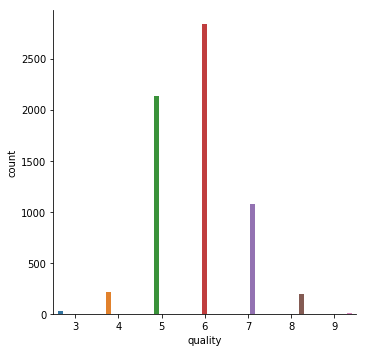

In [11]:
import seaborn as sns
print("Plot for the counts of observations in each quality using bars.")
sns.catplot("quality", data=data, hue='quality', kind="count");

As we can see, the response variable `quality` is unbalanced and probably we'll have to handle it later.

## Preparing data

In this section, we will prepare the data for modeling, training and testing.

## Identify feature and target columns

It is often the case that the data contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

The code cell below will separate the wine data into feature and target columns to see if any features are non-numeric.

In [108]:
# Extract feature columns
feature_cols = list(data.columns[:-1])

# Extract target column 'quality'
target_col = data.columns[-1] 

# Show the list of columns
print("Feature columns:\n{}".format(feature_cols))
print("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = data[feature_cols]
y_all = data[target_col]

# Show the feature information by printing the first five rows
print("\nFeature values:")
display(X_all.head())

print("\nFeature types")
print(X_all.dtypes)

print("\nClasses from type feature:")
print(data['type'].unique())

Feature columns:
['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Target column: quality

Feature values:


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9



Feature types
type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                  object
dtype: object

Classes from type feature:
['White' 'Red']


## Preprocess Feature Columns

As we can see, there two non-numeric features that need to be converted: `type` and `alcohol`.

The `type` feature only has two classes (`['White' 'Red']`), so it can be reasonably converted into 1/0 (binary) values.

The `alcohol` feature is actually a numeric feature, but some rows are wrong non-numeric values, for example `'110.666.666.666.667'`, `'956.666.666.666.667'`, `'923.333.333.333.333'` and so on. Therefore, we will parse the values of this feature into numeric values and replace the wrong values with the mean of all of the values for the feature ([reference](https://machinelearningmastery.com/handle-missing-data-python/)).
 


In [109]:

def preprocess_features(X):
    ''' Preprocesses the data and converts non-numeric binary variables into
        binary (0/1) variables.'''

    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If type, replace all 'White'/'Red' values with 1/0
        if col == 'type' and col_data.dtype == object:
            col_data = col_data.replace(['White', 'Red'], [1, 0])
        
        # If alcohol, parse it values to numberic and coerce the convertion errors
        if col == 'alcohol' and col_data.dtype == object:
            col_data = pd.to_numeric(col_data, errors='coerce')

        # Collect the revised columns
        output = output.join(col_data)

    # handle NaN values by inputting the mean
    output.fillna(output.mean(), inplace=True)
    
    return output

X_all = preprocess_features(X_all)